***Programming Problems of ESO208 Assignment 1***

In [102]:
# import all relevant libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Question 3 (Geodesy using Vincenty's Formula)

In [103]:
# subpart i

# we define a function called, vincenty_geodesy_calculator(), which takes in 4 arguments

# lat1 :  latitude of point 1 in degrees
# long1 : longitude of point 1 in degrees
# lat2 :  latitude of point 2 in degrees
# long2 : longitude of point 2 in degrees

# and returns the geodesy in metres
def vincenty_geodesy_calculator(lat1,long1,lat2,long2):

  # define the constants required in the calculations
  PI = 3.14159265359
  f = 1/298.257223563 # flattening
  b = 6356752.3142 # semi-minor axis in metres

  # we can calculate a, the semi-major axis from the definition of flattening, f = (a-b)/a
  # which means that a = b/(1-f)
  a = b / (1-f) # semi-major axis in meters, which comes out to be around 6378137.0 metres

  # we need to convert the latitudes and longitudes to radians
  lat1_rad = PI * (lat1)/180
  lat2_rad = PI * (lat2)/180
  long1_rad = PI * (long1)/180
  long2_rad = PI * (long2)/180

  # calculate the reduced latitudes, U1 and U2
  U1 = np.arctan((1-f) * np.tan(lat1_rad))
  U2 = np.arctan((1-f) * np.tan(lat2_rad))

  # intial difference in the longitude
  L = long2_rad - long1_rad

  # sine and cosine of the reduced latitude
  sinU1 = np.sin(lat1_rad) * np.cos(U1)
  cosU1 = np.cos(lat1_rad) * np.cos(U1)
  sinU2 = np.sin(lat2_rad) * np.cos(U2)
  cosU2 = np.cos(lat2_rad) * np.cos(U2)

  # now we begin the iterative calculations, which will be in a while loop until
  # our iteration parameter is less than the tolerance

  # define and initialize Lambda = long2 - long1 = L , our iteration parameter
  Lambda_old = L

  # tolerance limit
  Tolerance = 1e-100

  # final values of variables of interest initialised with None for now, as variables defined within while loops
  # won't be visible to outer scope
  cos2_alpha_f = None
  sigma_f = None
  cos_2sigma_m_f = None

  # iterations begin
  while(True):

    sin_lambda = np.sin(Lambda_old)
    cos_lambda = np.cos(Lambda_old)

    sin_sigma = np.sqrt((cosU2 * sin_lambda)**2 + (cosU1 * sinU2 - sinU1 * cosU2 * cos_lambda)**2)
    cos_sigma = sinU1 * sinU2 + cosU1 * cosU2 * cos_lambda

    sigma = np.arctan2(sin_sigma, cos_sigma)

    sin_alpha = cosU1 * cosU2 * sin_lambda / sin_sigma
    cos2_alpha = 1 - sin_alpha ** 2 # cos2_alpha denotes cos^2 alpha

    cos_2sigma_m = cos_sigma - 2 * sinU1 * sinU2 / cos2_alpha

    C = f * cos2_alpha * (4 + f*(4-3*cos2_alpha)) / 16

    Lambda_new = L + (1 - C) * f * sin_alpha * (sigma + C * sin_sigma * (cos_2sigma_m + C * cos_sigma * (-1 + 2 * (cos_2sigma_m**2))))

    # check the difference between Lambda_new and Lambda_old, if satisfied update final values and break out of the while loop
    if(abs((Lambda_new - Lambda_old)/Lambda_new) < Tolerance):
      cos2_alpha_f = cos2_alpha
      sigma_f = sigma
      cos_2sigma_m_f = cos_2sigma_m
      break

    # if break condition not satisfied,
    # update Lambda_old for the next iteration
    Lambda_old = Lambda_new

  # sin and cosine for final sigma
  sin_sigma = np.sin(sigma_f)
  cos_sigma = np.cos(sigma_f)

  # final geodesy calculations
  u_2 = cos2_alpha_f * (a**2 - b**2)/ b**2

  A = 1 + u_2 * (4096 + u_2 * (-768 + u_2 * (320 - 175 * u_2))) / 16384
  B = u_2 * (256 + u_2 * (-128 + u_2 * (74 - 47 * u_2))) / 1024

  delta_sigma = B*sin_sigma*(cos_2sigma_m_f+B*(cos_sigma*(-1+2*(cos_2sigma_m_f**2))-B*cos_2sigma_m_f*(-3+4*(sin_sigma**2)*(-3+4*(cos_2sigma_m_f**2)))/6)/4)

  # return the calculated geodesy
  return b*A*(sigma_f - delta_sigma)



In [104]:
# subpart ii

# calculation of distance between hometown and IIT Kanpur

# positive latitudes mean North and vice-versa
# positive longitudes mean East and vice-versa

# Chandrapur (Hometown) Coordinates in degrees
# Source: https://www.latlong.net/place/chandrapur-maharashtra-india-14246.html
lat1 = 19.970324
long1 = 79.303360

# IITK Coordinates in degrees
# Source: https://latitude.to/articles-by-country/in/india/4629/indian-institute-of-technology-kanpur
lat2 = 26.511383
long2 = 80.23493


# vincenty_geodesy_calcualtor function call
original_distance = vincenty_geodesy_calculator(lat1,long1,lat2,long2)

print(f"The distance between IIT Kanpur and my hometown Chandrapur is {original_distance} metres")


The distance between IIT Kanpur and my hometown Chandrapur is 733202.2367775806 metres


In [105]:
# subpart iii

# we add small perturbation to latitude 1 to see the effect on the geodesy
delta_lat = 0.0001
perturbed_distance = vincenty_geodesy_calculator(lat1 + delta_lat,long1,lat2,long2)

print(f"The distance between IIT Kanpur and my hometown Chandrapur (perturbed latitude) is {perturbed_distance} metres")

The distance between IIT Kanpur and my hometown Chandrapur (perturbed latitude) is 733191.2457779995 metres



The original distance is 733202.2367775806 metres


The perturbed distance is 733191.2457779995 metres


The forward error is -10.990999581059441 metres



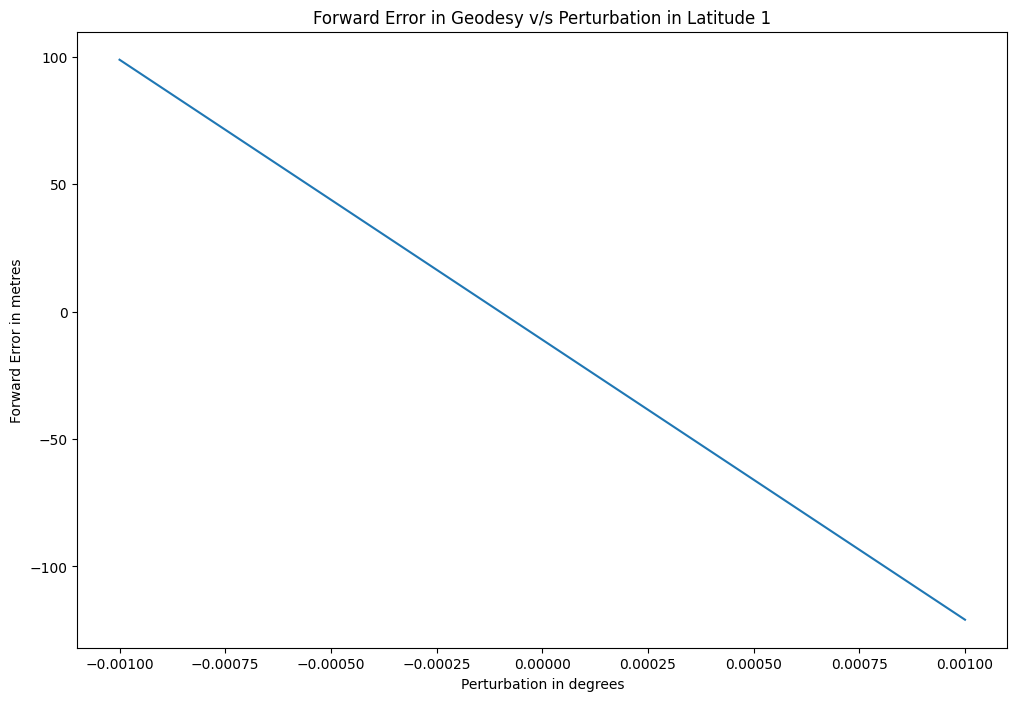

In [106]:
# subpart iv (method 1: taylor's series approximation)

# backward error analysis

# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# calculation of required data for backward error analysis
original_distance = vincenty_geodesy_calculator(lat1,long1,lat2,long2)
delta_lat = 0.0001
perturbed_lat1 = lat1 + delta_lat
perturbed_distance = vincenty_geodesy_calculator(perturbed_lat1 ,long1,lat2,long2)

# for small changes in input parameter, we know that we can approximate the nearby functional values without actually evaluating the the function at those points
# by using first order taylor's approximation

# we try to check the validity of the first order taylor's approximation in this case by plotting the change in change in geosdesy v/s values near the perturbed latitude
# small neighbourhood to check the validity of the taylor's approximation in this case
h = 0.001
neighbourhood = np.linspace(-h,h,num=1000)

# where vgcs() is the shorthand of the wrapper function, vincenty_geodesy_calculator_short,
# we define this for the ease of calling function
def vgcs(x):
  return vincenty_geodesy_calculator(x,long1,lat2,long2)

# in python, functions don't accept vector or list-like inputs, they accept only single values
# so to make the function capable of accepting vector inputs,
# we use the vectorize() method in the numpy library
# where prefix v_ denotes the vectorized version of the function
# i have followed this prefix notation everywhere vectorization is done
v_vgcs = np.vectorize(vgcs)

# deviation in the geodesy for the small changes in input
y = v_vgcs(perturbed_lat1 + neighbourhood) - original_distance

# values of geodesy for original_lat1 and perturbed_lat1
print(f"\nThe original distance is {original_distance} metres\n")
print(f"\nThe perturbed distance is {perturbed_distance} metres\n")
print(f"\nThe forward error is {perturbed_distance - original_distance} metres\n")

# adjust plot dimensions
fig = plt.figure()
fig.set_figwidth(12)
fig.set_figheight(8)

# plotting commands
plt.plot(neighbourhood,y)
plt.title("Forward Error in Geodesy v/s Perturbation in Latitude 1")
plt.xlabel("Perturbation in degrees")
plt.ylabel("Forward Error in metres")
plt.show()

# we note that the value of the forward error lies in the region where the behavoiur can aprroximated as linear
# hence the use of taylor's approximation is justified


In [107]:
# subpart iv (method 1.... continued)

# from the above graph it is clear that the linear taylor series approximation is a good model for small perturbations and hence we can use it to calucalte the backward error
# we can say that , f(x) = f(x') + f'(x') * (x-x')

# since we know the
# perturbed_latitude : x'
# original_distance : f(x)
# perturbed_distance : f(x')
# and we can calculate the slope at x' i.e. f'(x')

# hence we can calculate Δx and from it, the backward error or correction

# calculation
slope = (vgcs(perturbed_lat1+h) - vgcs(perturbed_lat1))/h
backward_error = (original_distance - perturbed_distance)/slope

print(f"\nThe Backward Error is {backward_error} degrees")

# hence the relative change in perturbed latitude required is
print(f"\nRelative change required is {backward_error/perturbed_lat1}")


The Backward Error is -0.00010000016542951334 degrees

Relative change required is -5.007413234166352e-06


In [108]:
# subpart iv (alternate method 2: via root finding techniques)

# data
lat1 = 19.970324
long1 = 79.303360

lat2 = 26.511383
long2 = 80.23493

original_distance = vincenty_geodesy_calculator(lat1,long1,lat2,long2)

delta_lat = 0.0001
perturbed_lat1 = lat1 + delta_lat
perturbed_distance = vincenty_geodesy_calculator(perturbed_lat1 ,long1,lat2,long2)

# now to determine the relative change in latitude which will make the perturbed distance same as original distance,
# we do backward error analysis.

# first we try to determine the perturbation which was added to the actual latitude,
# we can do that by finding the zero of the polynomial f(x) = vgcs(x) - original_distance

# where vgcs() is the shorthand of the wrapper function, vincenty_geodesy_calculator_short,
def vgcs(x):
  return vincenty_geodesy_calculator(x,long1,lat2,long2)

# to find the root of the equation f(x) = 0 nearest to perturbed_lat1,

# we will use the Secant Method iteratively,
# x = x' - f(x') * (x'-x") / (f(x')-f(x")), where x' and x" are the values of x found in previous 2 iterations respectively

# this method requires two intial values to begin the iterations
# although this method doesn't guarantee convergence, we can use this method as the "ROOT" is very close to the perturbed value

# for the nearest root as mentioned above, we need to give values close to the root,
# so, the perturbed latitude and the perturbed latitude with some more(small) perturbation is a good choice

# this array will contain the successively improved estimates of the roots of the eqaution f(x) = 0
# this array's last element will contain our best aprroximation for the root
xn = [perturbed_lat1, perturbed_lat1 + 0.1]

# now we begin the iterations with tolerance
Tolerance = 1e-12

while(True):
  p = vgcs(xn[-1]) - original_distance
  q = vgcs(xn[-2]) - original_distance
  xn.append(xn[-1] - p * (xn[-1]-xn[-2]) / (p-q))

  if(abs((xn[-1]-xn[-2])/xn[-1]) < Tolerance):
    break

# now we check whether our estimate for the root of the equation f(x) = 0 is close to the real value
# we can do this by comparing the correction required to make the perturbed latitude into the original latitude,
# and the
# original latitude = perturbed latitude - correction, which means
# correction = perturbed latitude - original latitude
required_correction = lat1 - perturbed_lat1
estimated_correction = xn[-1] - perturbed_lat1 # this is the backward error calculated


print(f"The correction required in the perturbed latitude is {required_correction} degrees")
print(f"\nAnd the estimated backward error is {estimated_correction} degrees\n")

# we see that the correction is very close to 1e-4, which was indeed the perturbation we added to the original latitude at the beginning of this question

# so the relative change is correction / perturbed latitude
print(f"The relative change to be done in the perturbed latitude is {estimated_correction/perturbed_lat1}")

The correction required in the perturbed latitude is -9.999999999976694e-05 degrees

And the estimated backward error is -0.00010000000000331966 degrees

The relative change to be done in the perturbed latitude is -5.00740495060694e-06


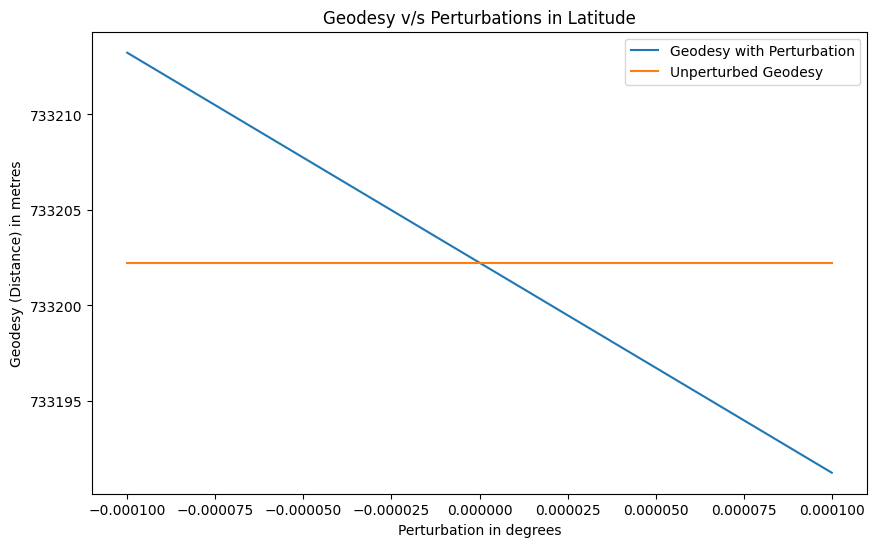

In [109]:
# subpart v

# define constant function to vectorize for highlighting the base distance
def const_1(x):
  return 1;

# perturbation to add and zero perturbation vectors
range = np.linspace(-0.0001,0.0001)
zero = np.zeros(50)

# vectorize the required functions for plotting
v_const_1 = np.vectorize(const_1)
v_vgc = np.vectorize(vincenty_geodesy_calculator)

# values to be plotted, NOTE: perturbation is added only in lat1, others a re unperturbed (added only zero vector)
y = v_vgc(lat1+range,long1+zero,lat2+zero,long2+zero)
x = range

# adjust plot dimensions
fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(6)

# plotting commands
plt.plot(x,y)
plt.plot(x,zero+original_distance)
plt.title("Geodesy v/s Perturbations in Latitude")
plt.xlabel('Perturbation in degrees')
plt.ylabel('Geodesy (Distance) in metres')
plt.legend(['Geodesy with Perturbation','Unperturbed Geodesy'])
plt.show()


Question 4

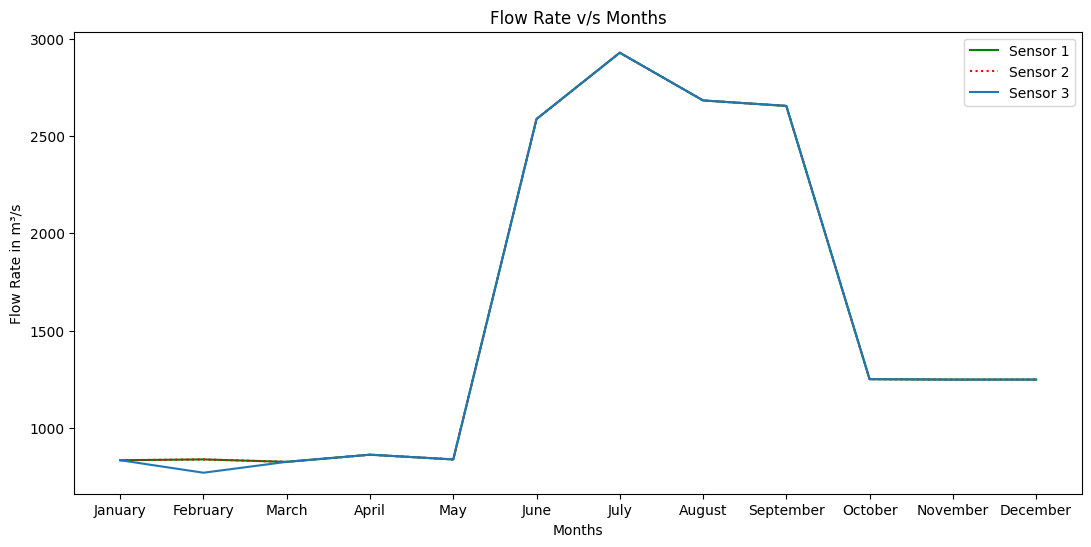

In [110]:
# subpart i

# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# import sensor data csv file
sensor_data = pd.read_csv('/content/drive/MyDrive/asgn_1_assets/sensor_data.csv')

# beacuse the data in the A and R columns of the dataframe is class <str> i.e string, we need to explicitly typecast it into
# float and create new Pandas Series for them

# get the data vectors
S1_A = sensor_data.iloc[1:,1]
S1_R = sensor_data.iloc[1:,3]
S2_A = sensor_data.iloc[1:,4]
S2_R = sensor_data.iloc[1:,6]
S3_A = sensor_data.iloc[1:,7]
S3_R = sensor_data.iloc[1:,9]

# convert to float function
def convert(s):
  return float(s)

# vectorize the convert function
v_convert = np.vectorize(convert)

# convert all string data to float
S1_A =  pd.Series(v_convert(S1_A))
S2_A =  pd.Series(v_convert(S2_A))
S3_A =  pd.Series(v_convert(S3_A))
S1_R =  pd.Series(v_convert(S1_R))
S2_R =  pd.Series(v_convert(S2_R))
S3_R =  pd.Series(v_convert(S3_R))

# define a function which takes necessary parameters as input, and returns the flow rate using Manning's Equation
def mannings_flow_rate(A,R):

  # Q = A * R ** (2/3) * S ** (1/2) / n   :  Manning's Equation

  # Q = Flow Rate in m³/s
  # A = Cross-Sectional Area of Flow in metres
  # R = Hydraulic Radius in metres
  # S = Slope of Energy Grade Line
  # n = Manning's Roughness Coefficient

  # Predefined Constants in Assignment
  n = 0.035
  S = 0.001

  return (A * pow(R,2/3) * pow(S,1/2) / n)

# vectorize mannings_flow_rate function
v_mannings_flow_rate = np.vectorize(mannings_flow_rate)

# data to plot
x = sensor_data.iloc[1:,0]
Q1 = v_mannings_flow_rate(S1_A,S1_R)
Q2 = v_mannings_flow_rate(S2_A,S2_R)
Q3 = v_mannings_flow_rate(S3_A,S3_R)

# adjust plot size
fig = plt.figure()
fig.set_figwidth(13)
fig.set_figheight(6)

# plotting commands
plt.plot(x,Q1,'-g')
plt.plot(x,Q2,':r')
plt.plot(x,Q3)
plt.title("Flow Rate v/s Months")
plt.ylabel("Flow Rate in m³/s")
plt.xlabel("Months")
plt.legend(['Sensor 1','Sensor 2','Sensor 3',])

plt.show()

In [111]:
# subpart ii

# import necessay libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# we first multiply each sensor value by 1000 and then truncate to integer and then divide by 1000 to get the effect of truncation to 3 decimal places
# as there is no inbuilt function in python which truncates numbers to given amount of decimal places
tS1_R = (np.trunc(S1_R * 1000))/1000
tS2_R = (np.trunc(S2_R * 1000))/1000
tS3_R = (np.trunc(S3_R * 1000))/1000

# calculate flow using truncated values of R from each of the sensors
tQ1 = v_mannings_flow_rate(S1_A,tS1_R)
tQ2 = v_mannings_flow_rate(S2_A,tS2_R)
tQ3 = v_mannings_flow_rate(S3_A,tS3_R)

# to find the truncation errors in R via backward analysis, we employ the first order taylor series approximation on Q with respect to R
# Q(R) = Q(R') + Q'(R') * ΔR

# we already know,
# flow due to truncated R : Q(R')
# flow due to original R: Q(R)
# truncated R: R'

# and we can find the slope of the graph, changes Q(R) v/s R at R' (using finite difference in small neighbourhood around R')

# wrapper function for mannings_flow_rate for ease of use
def mfr(A,R):
  return mannings_flow_rate(A,R)

# backward error calculator does the analysis assuming first order taylor approximation
def R_backward_error_calculator(A,R_,Q,Q_):

  # small neighbourhood, h = 0.001, we select this value as we truncate the values of R to 3 decimal places so, this value is as small as the least
  # significant place in truncated R and can be justified as a small neighbourhood, also any truncation errors in R will be smaller than h
  # so if linear aprroximation is justified for h and it is surely justified for the truncation error as it is smaller than h
  h = 0.001

  return (Q-Q_) * h / (mfr(A,R_+h) - Q_)

# vectorize the R_backward_error_calculator function
v_R_bec = np.vectorize(R_backward_error_calculator)

# function call to v_R_bec function for all sensors
S1_estimated_trunc_errors_in_R = v_R_bec(S1_A,tS1_R,Q1,tQ1)
S2_estimated_trunc_errors_in_R = v_R_bec(S2_A,tS2_R,Q2,tQ2)
S3_estimated_trunc_errors_in_R = v_R_bec(S3_A,tS3_R,Q3,tQ3)


# we can verify that our backward error analysis was indeed correct by comparing the values of calculated truncated errors with the actual truncated errors
# alothough in practice we won't know the actual truncation errors while doinf the backward error analysis, this confirmation just reinforces the fact that
# for samll perturbations, first order taylor series aprroximation is an easy and robust tool for backward error analysis

# for example, check the values for sensor 3
print(pd.Series(S3_estimated_trunc_errors_in_R))
print()
print(S3_R - tS3_R)


0     0.000339
1     0.000108
2     0.000818
3     0.000821
4     0.000762
5     0.000615
6     0.000431
7     0.000790
8     0.000481
9     0.000643
10    0.000398
11    0.000072
dtype: float64

0     0.000339
1     0.000108
2     0.000818
3     0.000821
4     0.000762
5     0.000615
6     0.000431
7     0.000790
8     0.000481
9     0.000643
10    0.000398
11    0.000072
dtype: float64


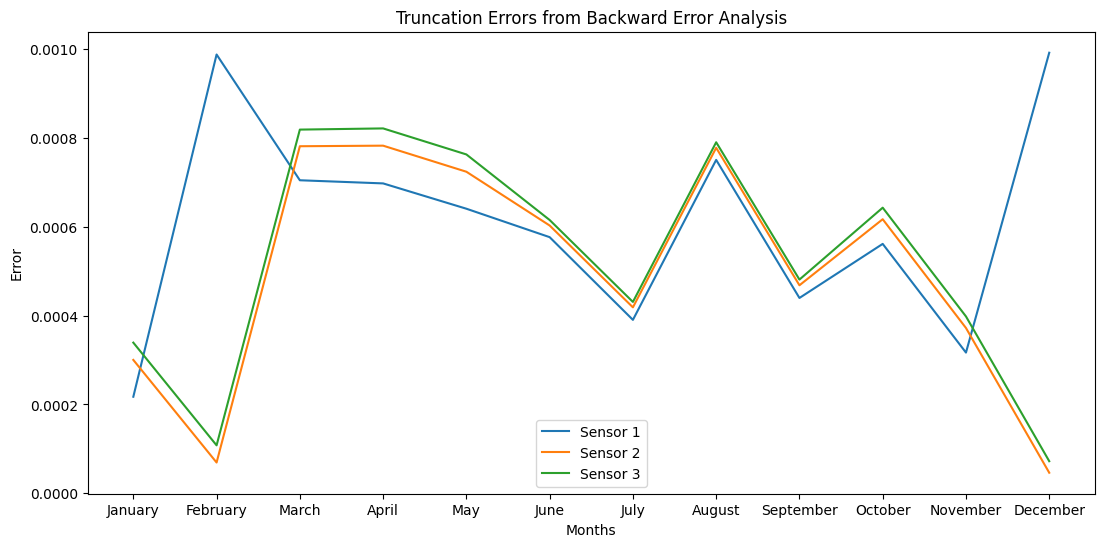

In [112]:
## we plot the truncation errors in R using backward error analysis calculated in the previous cell

# adjust plot size
fig = plt.figure()
fig.set_figwidth(13)
fig.set_figheight(6)

# plotting commands
plt.plot(x,S1_estimated_trunc_errors_in_R)
plt.plot(x,S2_estimated_trunc_errors_in_R)
plt.plot(x,S3_estimated_trunc_errors_in_R)
plt.legend(['Sensor 1','Sensor 2','Sensor 3',])
plt.title("Truncation Errors from Backward Error Analysis")
plt.ylabel("Error")
plt.xlabel("Months")
plt.show()


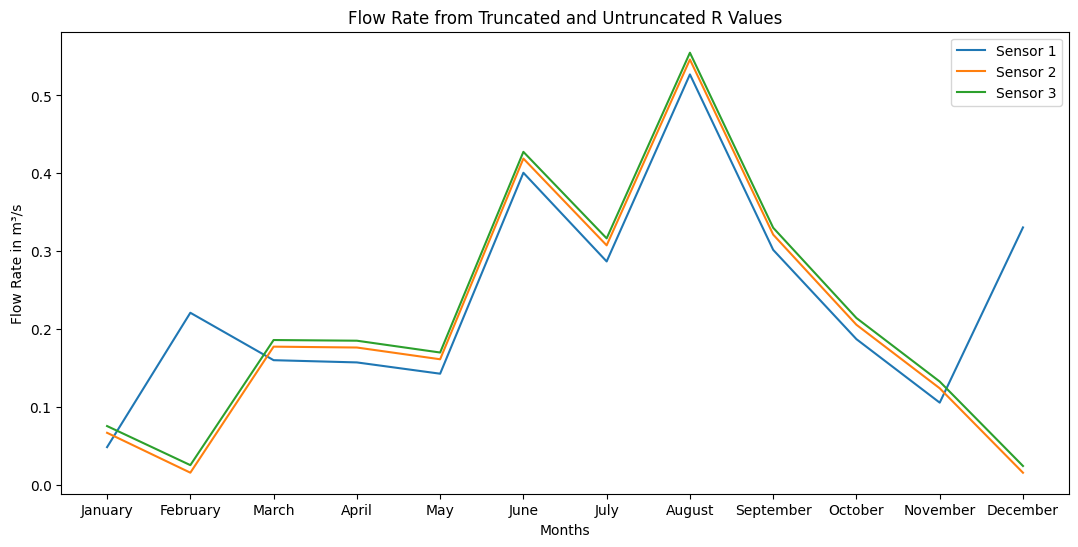

In [113]:
## we plot Q (flow rates)from both untruncated and truncated values to compare them

# adjust the plot size
fig = plt.figure()
fig.set_figwidth(13)
fig.set_figheight(6)

# plotting commands
plt.plot(x,Q1-tQ1)
plt.plot(x,Q2-tQ2)
plt.plot(x,Q3-tQ3)

plt.legend(['Sensor 1','Sensor 2','Sensor 3'])
plt.title("Flow Rate from Truncated and Untruncated R Values")
plt.xlabel("Months")
plt.ylabel("Flow Rate in m³/s")
plt.show()



In [114]:
# subpart iii

# we add pertubation as mentioned in the question for each sensor
pS1_R = S1_R + 0.0001
pS2_R = S2_R + 0.0001
pS3_R = S3_R + 0.0001

# flow rates calculated from perturbed R values for each sensor
pQ1 = v_mannings_flow_rate(S1_A,pS1_R)
pQ2 = v_mannings_flow_rate(S2_A,pS2_R)
pQ3 = v_mannings_flow_rate(S3_A,pS3_R)

# forward errors in Q due to perturbation in R for each sensor
forward_error_in_Q1 = pQ1-Q1
forward_error_in_Q2 = pQ2-Q2
forward_error_in_Q3 = pQ3-Q3

# backward error estimation in R from using first order taylor aprroximation for each sensor
estimated_backward_error_in_R1 = v_R_bec(S1_A,pS1_R,Q1,pQ1)
estimated_backward_error_in_R2 = v_R_bec(S2_A,pS2_R,Q2,pQ2)
estimated_backward_error_in_R3 = v_R_bec(S3_A,pS3_R,Q3,pQ3)


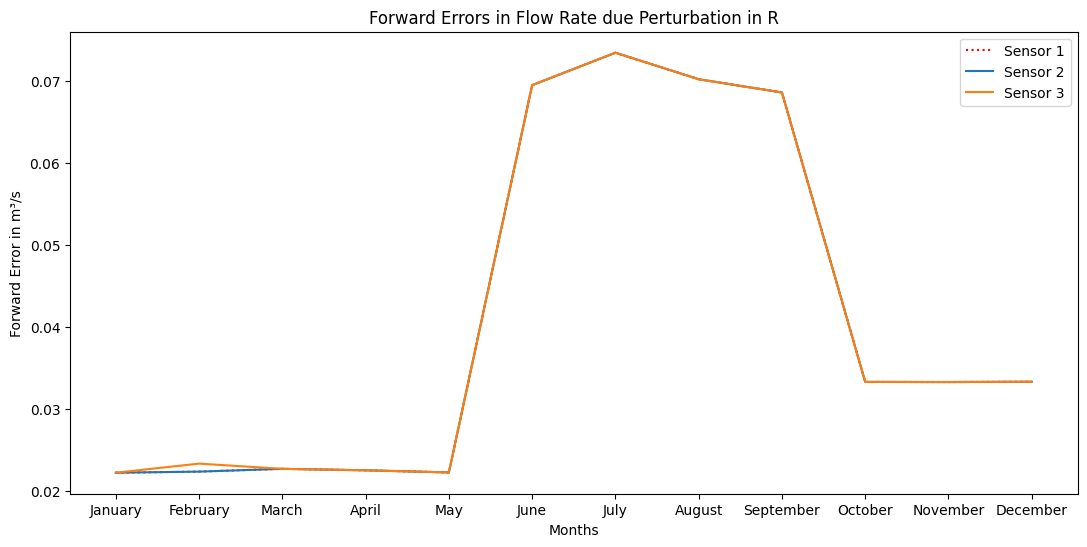

In [115]:
# plot of forward errors in Q

# adjust the plot size
fig = plt.figure()
fig.set_figwidth(13)
fig.set_figheight(6)

# plotting commands
plt.plot(x,forward_error_in_Q1,':r')
plt.plot(x,forward_error_in_Q2)
plt.plot(x,forward_error_in_Q3)
plt.legend(['Sensor 1','Sensor 2','Sensor 3',])
plt.title("Forward Errors in Flow Rate due Perturbation in R")
plt.xlabel("Months")
plt.ylabel("Forward Error in m³/s")
plt.show()


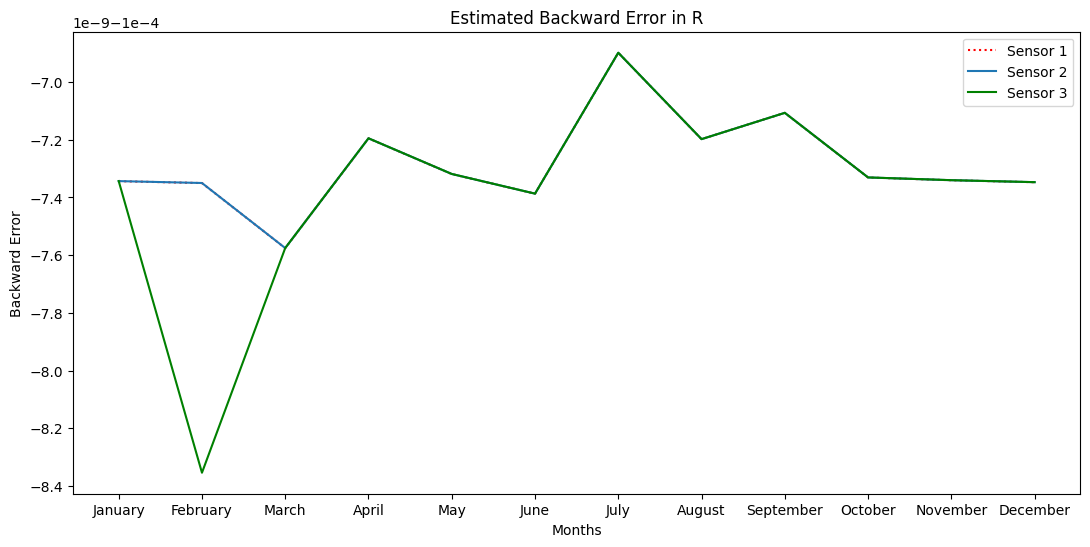

In [116]:
# plot the calculated backward error in R

# adjust the plot size
fig = plt.figure()
fig.set_figwidth(13)
fig.set_figheight(6)

# plotting commands
plt.plot(x,estimated_backward_error_in_R1,':r')
plt.plot(x,estimated_backward_error_in_R2)
plt.plot(x,estimated_backward_error_in_R3,'-g')
plt.legend(['Sensor 1','Sensor 2','Sensor 3'])
plt.title("Estimated Backward Error in R")
plt.xlabel("Months")
plt.ylabel("Backward Error")
plt.show()

Question 5

In [117]:
# subpart i

# the first four terms of the Maclaurin Series of sin(x) are x - x³/6 + x⁵/120 - x⁷/5040

# using PI = 3.14159265359 upto 11 decimal places
PI = 3.14159265359

# we define a truncated sin(x) function for this question
def trunc_sin(x):
  return x - (x**3)/6 + (x**5)/120 - (x**7)/5040

# value of trunc_sin() function at x = PI/6
print(f"The value of the truncated series approximaton of sin(x) as x = PI/6 is {trunc_sin(PI/6)}")

The value of the truncated series approximaton of sin(x) as x = PI/6 is 0.4999999918690531


In [118]:
# subpart ii

# we define the small disturbance, dx
dx = 0.000001
print(f"The small disturbance is, dx = {dx}")

# value of trunc_sin() function at x = PI/6 + dx
print(f"The value of the truncated series approximaton of sin(x) as x = PI/6 + dx is {trunc_sin(PI/6 + dx)}")

The small disturbance is, dx = 1e-06
The value of the truncated series approximaton of sin(x) as x = PI/6 + dx is 0.5000008578940673


In [119]:
# subpart iii

# we define the derivative of the truncated sin(x) function
def trunc_sin_der(x):
  return 1 - (x**2)/2 + (x**4)/24 - (x**6)/720

# sub subpart (a)

# condition number of a function f(x) at x is given by,

#             K_f(x) = | x*f'(x)/f(x) |

print(f"sub subpart (a)")
print(f"The condition number of trunc_sin at x = PI/6 is {abs((PI/6) * trunc_sin_der(PI/6) / trunc_sin(PI/6))}")


# sub subpart (b)



sub subpart (a)
The condition number of trunc_sin at x = PI/6 is 0.9068995505884508


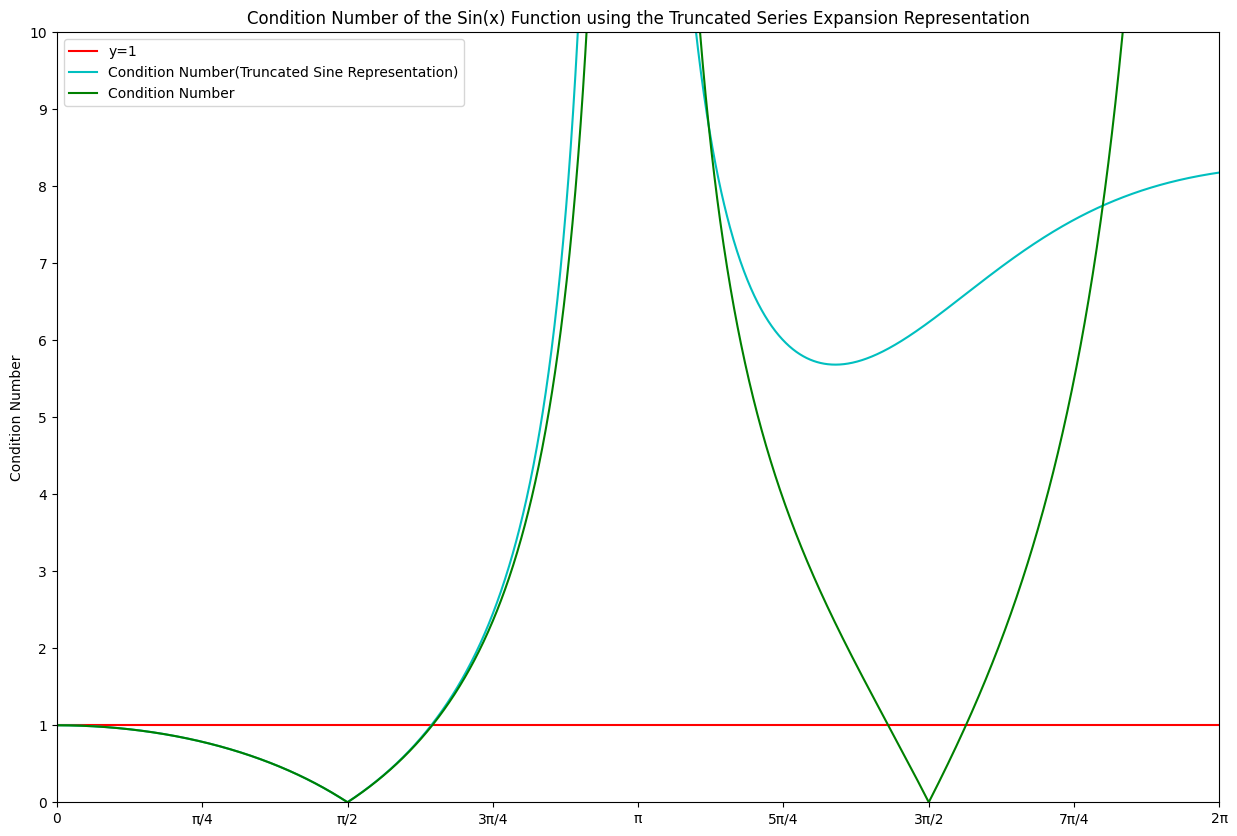

In [120]:
# sub subpart (c)

# import necessary libraries
import numpy as np

# define the condition numbers for both truncated series representation of sine and sine
def K_trunc_sin(x):
  return abs(x * trunc_sin_der(x) / trunc_sin(x))

def K_sin(x):
  return abs(x * np.cos(x) / np.sin(x))

# define a constant function to represent the y=1 line the condition number v/s x plot
def const_1(x):
  return 1;

# vectorize the functions
v_K_trunc_sin = np.vectorize(K_trunc_sin)
v_K_sin = np.vectorize(K_sin)
v_const_1 = np.vectorize(const_1)

# adjust the plot size
fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(10)

# data to plot and plotting commands
x = np.linspace(0,2*PI, num = 200)
y = v_const_1(x)
plt.plot(x,y,'-r')

# plotting from 0.000000000000001 instead 0 to avoid unnecessary division by zero errors
x = np.linspace(0.000000000000001,PI,num=1000, endpoint=False)
y1 = v_K_trunc_sin(x)
plt.plot(x,y1,'-c')

# plotting from 0.000000000000001 instead 0 to avoid unnecessary division by zero errors
x = np.linspace(0.000000000000001,PI,num=1000, endpoint=False)
y1 = v_K_sin(x)
plt.plot(x,y1,'-g')

x = np.linspace(PI,2*PI,num=1000, endpoint=False)
y2 = v_K_trunc_sin(x)
plt.plot(x,y2,'-c')

x = np.linspace(PI,2*PI,num=1000, endpoint=False)
y2 = v_K_sin(x)
plt.plot(x,y2,'-g')

plt.yticks([0,1,2,3,4,5,6,7,8,9,10],['0','1','2','3','4','5','6','7','8','9','10'])
plt.ylim(0,10)
plt.xticks([0,PI/4,PI/2,3*PI/4,PI,5*PI/4,3*PI/2,7*PI/4,2*PI],["0","π/4","π/2","3π/4","π","5π/4","3π/2","7π/4","2π"])
plt.xlim(0,2*PI)

plt.title("Condition Number of the Sin(x) Function using the Truncated Series Expansion Representation")
plt.legend(["y=1",'Condition Number(Truncated Sine Representation)', 'Condition Number'])
plt.ylabel("Condition Number")
plt.show()


sub subpart (d)

From the graph it is evident that the condition number is reasonably small (<=1) for values of x between 0 to roughly midway between π/2 and 3π/4 for both the truncated sine and sine, and some neighbourhood of 3π/2 for sine only. As the condition number is reasonably small for these values of x, the problem is said to be well-conditioned in this region.

sub subpart (e)

Condition number is basically the measure of how the output value of a function can change for a small change in the value input. So it is a good indicator of how sensitive a function is to changes or errors in input and how error in the output results from an error in the input

This is important in numerical computations as in an ill-conditioned method/model, small errors may be amplified to a large degree.

Hence, we always try to design methods/models with reasonably small condition numbers so that it is stable to small perturbations in input and does not unnecessarily amplify them in the output.